# ARIMA Model

In [21]:
# Load necessary packages
library(readr)
library(ggplot2)
library(forecast)

# Read the cleaned data
df <- read_csv("data/pm2.5_cleaned.csv")

# View first few rows
head(df)

# Convert Date to Date type (if not already)
df$Date <- as.Date(df$Date)

# Create a time series object
# Daily frequency, so we can treat it as frequency = 365 (approximate yearly cycle)
pm25_ts <- ts(df$PM2.5, frequency = 365, start = c(2018, 1))

# Check the structure
summary(pm25_ts)

Rows: 2557 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl  (1): PM2.5
date (1): Date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Date,PM2.5
<date>,<dbl>
2018-01-01,63.35
2018-01-02,43.88
2018-01-03,16.25
2018-01-04,25.55
2018-01-05,18.50
2018-01-06,16.25


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.60    8.44   11.60   12.80   15.35  148.90 

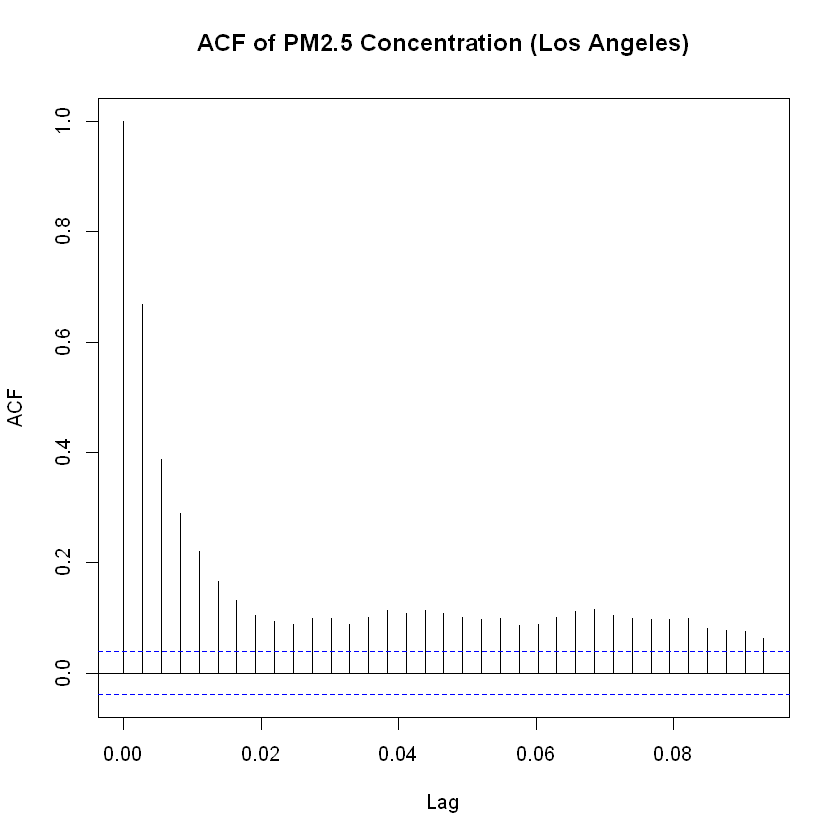

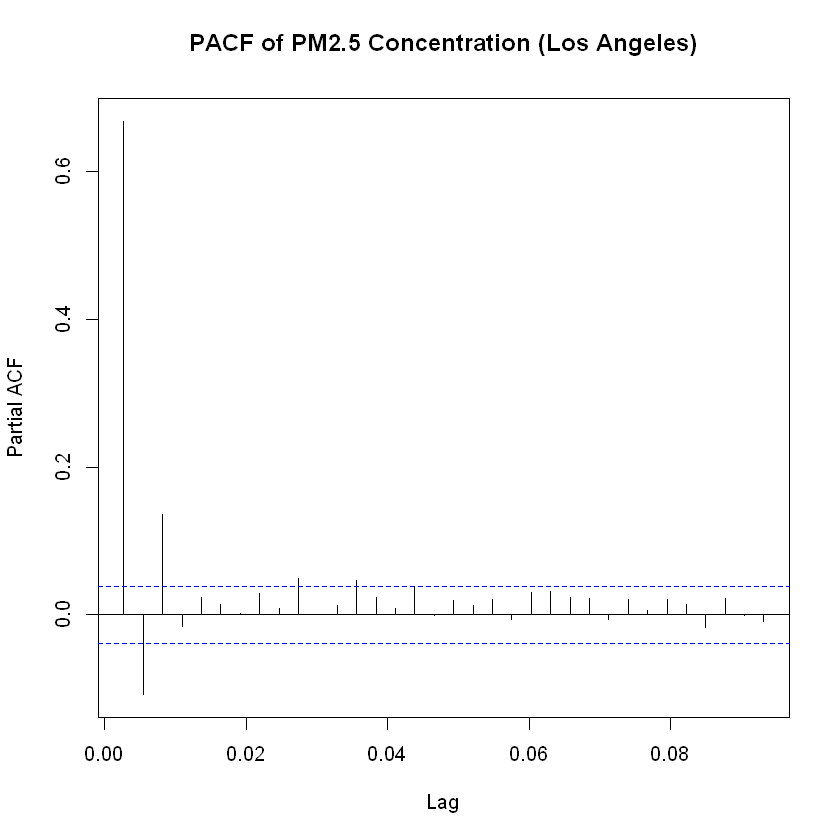

In [8]:
acf(pm25_ts, main = "ACF of PM2.5 Concentration (Los Angeles)")
pacf(pm25_ts, main = "PACF of PM2.5 Concentration (Los Angeles)")


In [9]:
library(tseries)
adf.test(pm25_ts)


Warning message in adf.test(pm25_ts):
"p-value smaller than printed p-value"



	Augmented Dickey-Fuller Test

data:  pm25_ts
Dickey-Fuller = -9.5755, Lag order = 13, p-value = 0.01
alternative hypothesis: stationary


Series: train_ts 
ARIMA(5,0,4) with non-zero mean 

Coefficients:
         ar1     ar2      ar3      ar4      ar5     ma1      ma2      ma3
      0.2114  1.0144  -0.0794  -0.0722  -0.0979  0.5487  -0.8017  -0.5046
s.e.  0.5412  0.1656   0.5934   0.1494   0.1241  0.5426   0.3065   0.4786
          ma4     mean
      -0.1017  13.0506
s.e.   0.2911   0.7082

sigma^2 = 29.87:  log likelihood = -6370.32
AIC=12762.64   AICc=12762.77   BIC=12824.49

Training set error measures:
                      ME     RMSE      MAE       MPE     MAPE      MASE
Training set -0.04353792 5.451693 3.174496 -14.12628 29.96969 0.9496255
                    ACF1
Training set -0.01567353

RMSE: 6.476191 
MAE: 4.647239 
MAPE: 0.4992722 
[1] 0


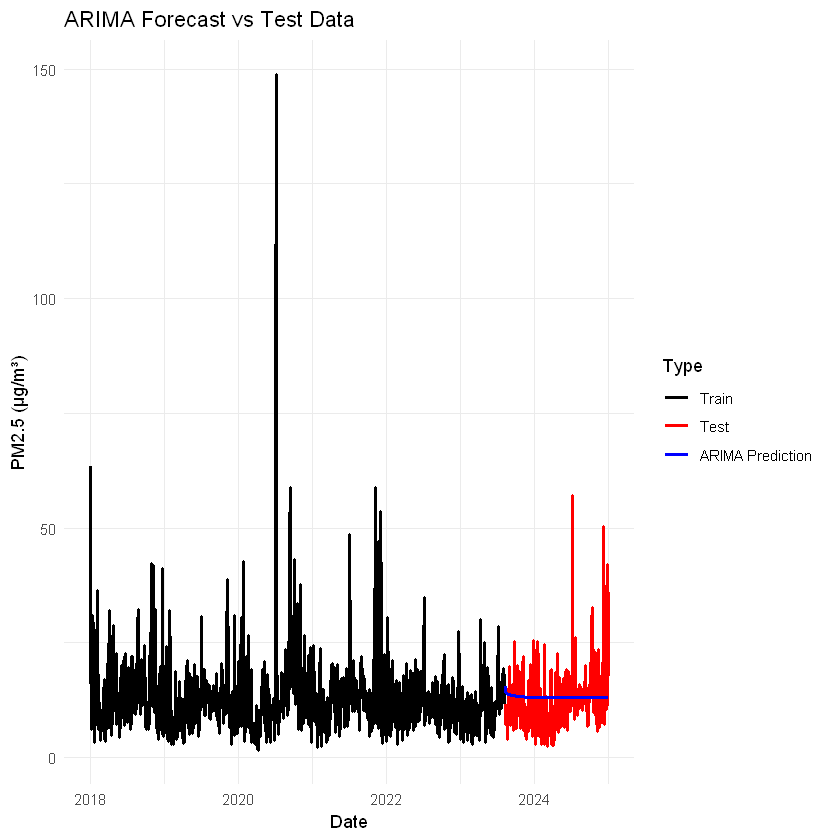

In [22]:
# -------------------------------
# Train/Test Split (80/20)
# -------------------------------
n <- length(pm25_ts)
train_size <- floor(n * 0.8)

train_ts <- pm25_ts[1:train_size]
test_ts  <- pm25_ts[(train_size + 1):n]

# -------------------------------
# Fit ARIMA model on training set
# -------------------------------
fit <- auto.arima(train_ts, seasonal = TRUE)
summary(fit)

# -------------------------------
# Forecast on test set
# -------------------------------
h <- length(test_ts)
pred <- forecast(fit, h = h)

# -------------------------------
# Calculate performance metrics
# -------------------------------
rmse_value <- rmse(test_ts, pred$mean)
mae_value  <- mae(test_ts, pred$mean)
mape_value <- mape(test_ts, pred$mean)
accuracy_df <- accuracy(pred$mean, test_ts) 

cat("RMSE:", rmse_value, "\n")
cat("MAE:", mae_value, "\n")
cat("MAPE:", mape_value, "\n")
print(accuracy_df)

# -------------------------------
# Plot: training + test + prediction
# -------------------------------
df_plot <- data.frame(
  Date = c(pm25_data$Date[1:train_size], pm25_data$Date[(train_size + 1):n]),
  PM25 = c(as.numeric(train_ts), as.numeric(pred$mean)),
  Type = c(rep("Train", train_size), rep("ARIMA Prediction", h))
)

df_test <- data.frame(
  Date = pm25_data$Date[(train_size + 1):n],
  PM25 = as.numeric(test_ts),
  Type = rep("Test", h)
)

df_plot <- rbind(df_plot, df_test)
df_plot$Type <- factor(df_plot$Type, levels = c("Train", "Test", "ARIMA Prediction"))

ggplot(df_plot, aes(x = Date, y = PM25, color = Type)) +
  geom_line(size = 1) +
  scale_color_manual(values = c("Train" = "black",
                                "Test" = "red",
                                "ARIMA Prediction" = "blue")) +
  theme_minimal() +
  ylab("PM2.5 (µg/m³)") +
  xlab("Date") +
  ggtitle("ARIMA Forecast vs Test Data")

In [19]:
adf.test(train_ts)


	Augmented Dickey-Fuller Test

data:  train_ts
Dickey-Fuller = -4.0486, Lag order = 4, p-value = 0.01294
alternative hypothesis: stationary



Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



Attaching package: 'lubridate'


The following objects are masked from 'package:base':

    date, intersect, setdiff, union


`summarise()` has grouped output by 'Year'. You can override using the
`.groups` argument.


Series: train_ts 
ARIMA(1,0,0) with non-zero mean 

Coefficients:
         ar1     mean
      0.3870  12.9338
s.e.  0.1139   0.6258

sigma^2 = 10.32:  log likelihood = -172.34
AIC=350.68   AICc=351.07   BIC=357.3

Training set error measures:
                      ME     RMSE     MAE       MPE     MAPE      MASE
Training set -0.03299263 3.164901 2.30803 -6.035663 18.86239 0.7842859
                   ACF1
Training set -0.0341813

RMSE: 3.364243 
MAE: 2.409079 
MAPE: 0.2065689 
[1] 0


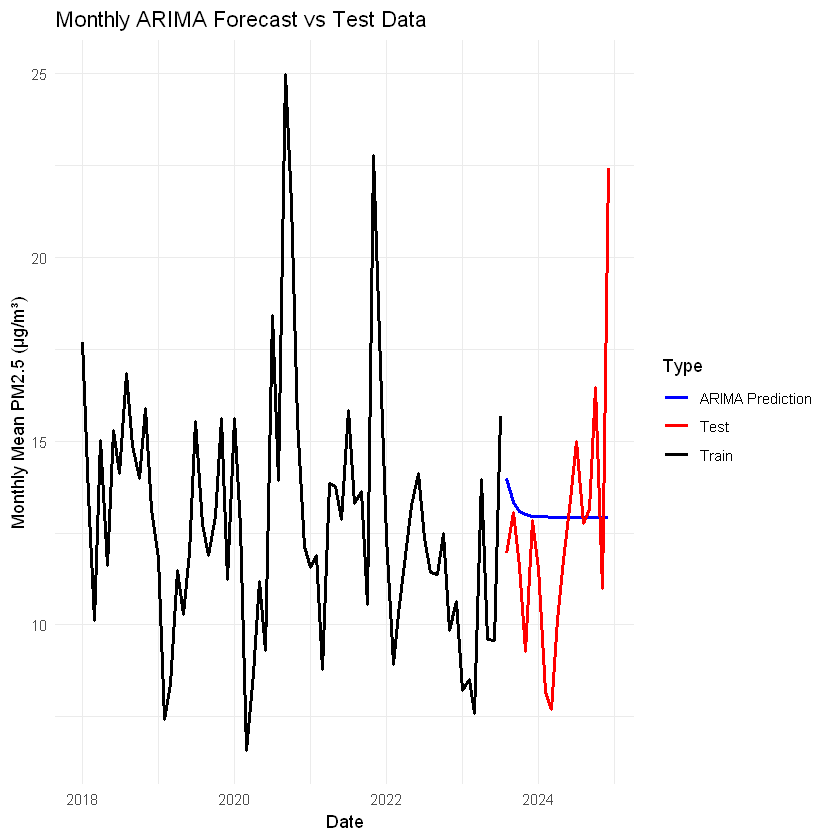

In [ ]:
# -------------------------------
# Aggregate to monthly mean
# -------------------------------
pm25_monthly <- pm25_data %>%
  mutate(Year = year(Date), Month = month(Date)) %>%
  group_by(Year, Month) %>%
  summarise(PM25 = mean(PM2.5, na.rm = TRUE)) %>%
  ungroup() %>%
  mutate(Date = as.Date(paste(Year, Month, "01", sep = "-")))

# -------------------------------
# 2b️⃣ Convert to monthly ts object
# -------------------------------
pm25_ts <- ts(pm25_monthly$PM25, start = c(min(pm25_monthly$Year), min(pm25_monthly$Month)), frequency = 12)

# -------------------------------
# 3️⃣ Train/Test Split (80/20)
# -------------------------------
n <- length(pm25_ts)
train_size <- floor(n * 0.8)

train_ts <- pm25_ts[1:train_size]
test_ts  <- pm25_ts[(train_size + 1):n]

# -------------------------------
# 4️⃣ Fit ARIMA model on training set
# -------------------------------
fit <- auto.arima(train_ts, seasonal = TRUE)
summary(fit)

# -------------------------------
# 5️⃣ Forecast on test set
# -------------------------------
h <- length(test_ts)
pred <- forecast(fit, h = h)

# -------------------------------
# 6️⃣ Calculate performance metrics
# -------------------------------
rmse_value <- rmse(test_ts, pred$mean)
mae_value  <- mae(test_ts, pred$mean)
mape_value <- mape(test_ts, pred$mean)
accuracy_df <- accuracy(pred$mean, test_ts)

cat("RMSE:", rmse_value, "\n")
cat("MAE:", mae_value, "\n")
cat("MAPE:", mape_value, "\n")
print(accuracy_df)

# -------------------------------
# 7️⃣ Plot: training + test + prediction
# -------------------------------
df_plot <- data.frame(
  Date = c(pm25_monthly$Date[1:train_size], pm25_monthly$Date[(train_size + 1):n]),
  PM25 = c(as.numeric(train_ts), as.numeric(pred$mean)),
  Type = c(rep("Train", train_size), rep("ARIMA Prediction", h))
)

df_test <- data.frame(
  Date = pm25_monthly$Date[(train_size + 1):n],
  PM25 = as.numeric(test_ts),
  Type = rep("Test", h)
)

df_plot <- rbind(df_plot, df_test)

ggplot(df_plot, aes(x = Date, y = PM25, color = Type)) +
  geom_line(size = 1) +
  scale_color_manual(values = c("Train" = "black",
                                "Test" = "red",
                                "ARIMA Prediction" = "blue")) +
  theme_minimal() +
  ylab("Monthly Mean PM2.5 (µg/m³)") +
  xlab("Date") +
  ggtitle("Monthly ARIMA Forecast vs Test Data")
